In [1]:
import re
import os
import pathlib
import time
import numpy as np
import pandas as pd
import matplotlib
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import LSTM, Dropout
from keras.layers import Embedding, TextVectorization
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
import nltk # for natural language processing
from nltk.corpus import stopwords # for removing english stopwords
from nltk.stem import WordNetLemmatizer # for term stemming
from prettytable import PrettyTable
import sklearn # for predictive data analysis
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from collections import defaultdict
from IPython.core.display import SVG
from IPython.core.interactiveshell import InteractiveShell # to modify Jupyter notebook configuration
InteractiveShell.ast_node_interactivity = "all" # so that all outputs in a cell are returned (instead of last instance)

# #Supress default INFO logging
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.CRITICAL)

In [2]:
# Load the fake and true news CSVs into Pandas dataframes
true_news = pd.read_csv('True.csv') 
fake_news = pd.read_csv('Fake.csv')

# Add column for fake/true target (true == 1, false == 0)
true_news['target'] = 1
fake_news['target'] = 0

# True and Fake news value counts - are they balanced?
print("Compare number of observations in true news and fake news data frames")
true_news['target'].value_counts()
print()
fake_news['target'].value_counts()
print()

Compare number of observations in true news and fake news data frames


1    21417
Name: target, dtype: int64

0    23481
Name: target, dtype: int64

In [3]:
# Remove random rows from fake_news (n = 2064) data frame so it has same number of rows as true_news
np.random.seed(5)
remove_n = 2064
drop_indices = np.random.choice(fake_news.index, remove_n, replace = False)
fake_news = fake_news.drop(drop_indices)

# Check that have same number of observations now
print("True and fake datasets should have same number of samples now...")
true_news['target'].value_counts()
print()
fake_news['target'].value_counts()
print()

# Preview first and last 5 rows in datasets to ensure they imported properly
print("Preview of the raw datasets to ensure they imported properly:")
true_news.head(-5)
print()
fake_news.head(-5)
print()

True and fake datasets should have same number of samples now...


1    21417
Name: target, dtype: int64

0    21417
Name: target, dtype: int64


Preview of the raw datasets to ensure they imported properly:


,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21407,"Mata Pires, owner of embattled Brazil builder ...","SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",worldnews,"August 22, 2017",1
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21409,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21410,Headless torso could belong to submarine journ...,COPENHAGEN (Reuters) - Danish police said on T...,worldnews,"August 22, 2017",1


,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0


In [4]:
# Combine true_news and fake_news data frames into one
dfs = [true_news, fake_news]
news_data = pd.concat(dfs)

# Concatenate text columns and isolate only relevant columns for analysis (i.e., text and target)
news_data['text'] = news_data['title'] + ' ' + news_data['text']
news_data = news_data[['text', 'target']]

# Check that binary values were assigned correctly
print("Dimensions of data frame that will be cleaned:")
news_data.shape # data frame dimensions
print()

print("First and last five rows of pre-cleaned concatenated dataset:")
news_data.head(-5) # first 5 and last 5 rows
print()

print("Null values by column:")
news_data.isnull().sum() # check for null values
print()

Dimensions of data frame that will be cleaned:


(42834, 2)


First and last five rows of pre-cleaned concatenated dataset:


,text,target
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
23471,Seven Iranians freed in the prisoner swap have...,0
23472,#Hashtag Hell & The Fake Left By Dady Chery a...,0
23473,Astroturfing: Journalist Reveals Brainwashing ...,0
23474,The New American Century: An Era of Fraud Paul...,0



Null values by column:


text      0
target    0
dtype: int64

In [5]:
# Instantiate WordNetLemmatizer() -- reduce words to their roots
wnl = WordNetLemmatizer()

# Download multilingual Wordnet data from OMW
nltk.download('omw-1.4')

# List of english stopwords
nltk.download('stopwords') 
stop_words = set(stopwords.words('english'))

# Download english dictionary ('wordnet')
nltk.download('wordnet');

# Download pre-trained GloVe embeddings using the following commands: 
# "wget http://nlp.stanford.edu/data/glove.6B.zip"
# "unzip -q glove.6B.zip"

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ZLoken\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZLoken\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZLoken\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def data_cleaning(row):
    row = row.lower() # convert text into lowercase
    row = re.sub('[^a-zA-Z]', ' ', row) # remove number and special characters using regex (keep words only)
    token = row.split() # split the data into tokens
    news = [wnl.lemmatize(word) for word in token if not word in stop_words] # lemmatize the words and remove any stopwords (e.g., a, an, the, etc.)
    row_clean = [word for word in news if len(word) >= 3] # only keep words greater than or equal to length of 3
    cleaned_news = ' '.join(row_clean) # join all tokenized words with space in between 
    
    return cleaned_news

In [7]:
# Clean the data - might take a couple minutes to run.
news_data['text'] = news_data['text'].apply(lambda x : data_cleaning(x)) # 'text' column gets cleaned
print("First and last five rows after cleaning the data:")
news_data.head(-5) # check that cleaning went as planned
print()

First and last five rows after cleaning the data:


,text,target
0,budget fight loom republican flip fiscal scrip...,1
1,military accept transgender recruit monday pen...,1
2,senior republican senator let mueller job wash...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump want postal service charge much amazon s...,1
...,...,...
23471,seven iranian freed prisoner swap returned ira...,0
23472,hashtag hell fake left dady chery gilbert merc...,0
23473,astroturfing journalist reveals brainwashing t...,0
23474,new american century era fraud paul craig robe...,0


In [8]:
# Check for null values
print("Null values by column:")
news_data.isnull().sum() # want zero null values
print()

# Check number unique values in each column
print("Unique values by column:")
news_data.nunique() # number unique values in each column
print()

Null values by column:


text      0
target    0
dtype: int64


Unique values by column:


text      37681
target        2
dtype: int64

In [9]:
# Isolate the target and text features
target = news_data['target'] # target values
text_dataset = news_data['text'] # predictor text features

# Check first and last 5 rows of target and text datasets
target.head(-5)
text_dataset.head(-5)

0        1
1        1
2        1
3        1
4        1
        ..
23471    0
23472    0
23473    0
23474    0
23475    0
Name: target, Length: 42829, dtype: int64

0        budget fight loom republican flip fiscal scrip...
1        military accept transgender recruit monday pen...
2        senior republican senator let mueller job wash...
3        fbi russia probe helped australian diplomat ti...
4        trump want postal service charge much amazon s...
                               ...                        
23471    seven iranian freed prisoner swap returned ira...
23472    hashtag hell fake left dady chery gilbert merc...
23473    astroturfing journalist reveals brainwashing t...
23474    new american century era fraud paul craig robe...
23475    hillary clinton israel first peace middle east...
Name: text, Length: 42829, dtype: object

In [10]:
# Split the data into training and test subsets
train_data, test_data, train_target, test_target = train_test_split(text_dataset, target, random_state = 5, train_size = 0.80)

# Check the split from into training and testing datasets
train_data.head(-5)
test_data.head(-5)

15773    breaking baltimore riot video report black gue...
17245    afghan school closing due violence undermining...
2139     house intelligence committee trump lied obama ...
14147    coincidence extradites romanian hacker clinton...
10862    priceless home depot founder zing liberal pres...
                               ...                        
15139    rand paul pick fight wrong senator say cruz pr...
14627    holy betrayal america national security new ev...
16103    france keen avoid student anger plan billion e...
13272    nfl denies dallas cowboy request honor slain p...
13602    funny moron crooked hillary frighten every ame...
Name: text, Length: 34262, dtype: object

16911    baghdad must show restraint respect kurdish ri...
20004    flame raced along train west london station ey...
12384    breaking trump reportedly considering ted cruz...
8299     revealed one hillary clinton goldman sachs spe...
6463     hillary clinton nyc mayor probably rumor persi...
                               ...                        
4277     melania quite possibly tried troll press style...
13976    hysterical guy spent majority term golf course...
3101     sean hannity stupid know retweeted anti trump ...
14586    trump make big announcement fox news say keep ...
867      house committee want document former trump aid...
Name: text, Length: 8562, dtype: object

In [11]:
# Convert the text_dataset, train_data, and test_data data frames to a tensor
train_data = tf.convert_to_tensor(train_data, dtype = tf.string) # train data
test_data = tf.convert_to_tensor(test_data, dtype = tf.string) # test data
train_target = tf.convert_to_tensor(train_target, dtype = tf.int32) # train data
test_target = tf.convert_to_tensor(test_target, dtype = tf.int32) # test data
text_dataset = tf.convert_to_tensor(text_dataset, dtype = tf.string) # text dataset (train and test combined) for full vocabulary

# Double check conversion to tensor
test_data
train_target

<tf.Tensor: shape=(8567,), dtype=string, numpy=
array([b'baghdad must show restraint respect kurdish right france say paris reuters france friday called iraq central government show restraint taking control last district oil rich province kirkuk said baghdad take right kurd fully account iraqi force seeking reestablish baghdad authority territory kurdish force occupied outside official boundary autonomous region mostly seized since course war islamic state militant ask federal government show restraint fully respect right kurd foreign ministry spokeswoman agnes romatet espagne told reporter ten thousand kurd fled kirkuk tuz two main city kurdish autonomous region erbil sulaimaniya according kurdish official united nation expressed concern thursday report forced displacement destruction kurdish home business mainly tuz romatet espagne said kurd also needed accept dialogue baghdad within framework constitution',
       b'flame raced along train west london station eye witness london reut

<tf.Tensor: shape=(34267,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 1, 0])>

In [12]:
# List of different values to try for TfidVectorizer max_features (i.e., top key words)
key_words = [100, 200, 500, 1000, 5000] # How many of the top key words to keep - iterate over list
n_grams = [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)] # ngram_range dictates if we keep 1 word (1, 1), 1 or 2 words (1, 2) etc.
max_len = [300, 600] # sequence length to pad the outputs to

['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 98 words (2 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (1, 1), and padded length of 300 is:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          10200     
                                                                 
 conv1d (Conv1D)             (None, 300, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 128)         0         
 )                                                               
                                                                 
 lstm (LSTM)         

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f922014a60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

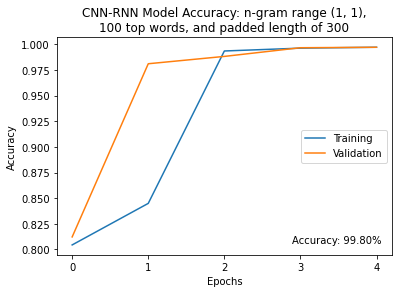

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f922475130>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

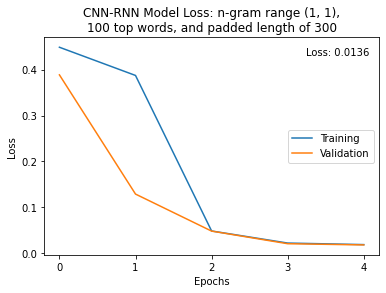

Updated model metrics for top 100 words, an n-gram range of (1, 1), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length       loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_100words_(1, 1)range_300maxLength.tf  (1, 1)             100              300  0.0135677     99.8016         267.499



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 98 words (2 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (1, 1), and padded length of 600 is:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 600, 100)          10200     
                                                                 
 conv1d_1 (Conv1D)           (None, 600, 128)          64128     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 300, 128)         0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)     

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f9258ee400>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

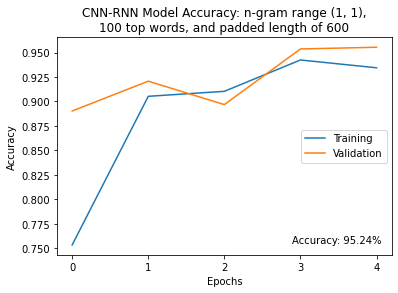

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92bf77130>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

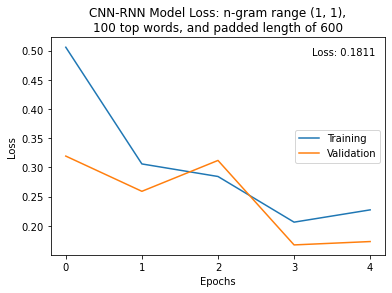

Updated model metrics for top 100 words, an n-gram range of (1, 1), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_100words_(1, 1)range_600maxLength.tf  (1, 1)             100              600  0.181125     95.2375          536.84



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 198 words (2 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (1, 1), and padded length of 300 is:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 300, 100)          20200     
                                                                 
 conv1d_2 (Conv1D)           (None, 300, 128)          64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)    

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f917789e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

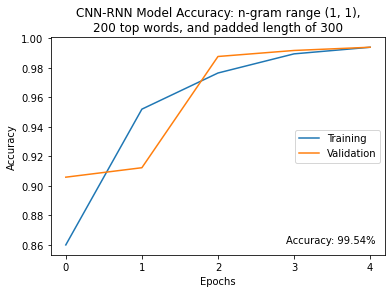

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f921f4d460>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

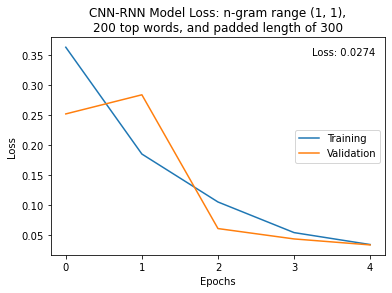

Updated model metrics for top 200 words, an n-gram range of (1, 1), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length       loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_200words_(1, 1)range_300maxLength.tf  (1, 1)             200              300  0.0274346     99.5448         378.602



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 198 words (2 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (1, 1), and padded length of 600 is:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 600, 100)          20200     
                                                                 
 conv1d_3 (Conv1D)           (None, 600, 128)          64128     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 300, 128)         0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)    

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n200 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f926fe39a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

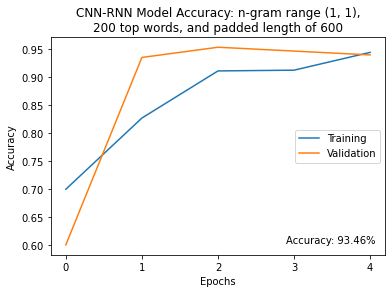

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n200 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92c07e5e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

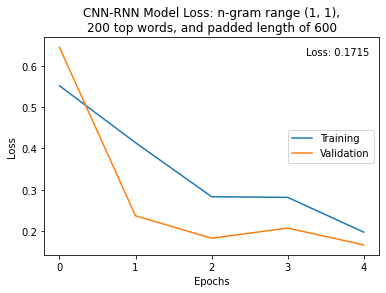

Updated model metrics for top 200 words, an n-gram range of (1, 1), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_200words_(1, 1)range_600maxLength.tf  (1, 1)             200              600  0.171519     93.4633         515.679



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 497 words (3 misses)

CNN-RNN hybrid model structure using top 500 words, an n-gram range of (1, 1), and padded length of 300 is:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 300, 100)          50200     
                                                                 
 conv1d_4 (Conv1D)           (None, 300, 128)          64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)    

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n500 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92cc95a30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

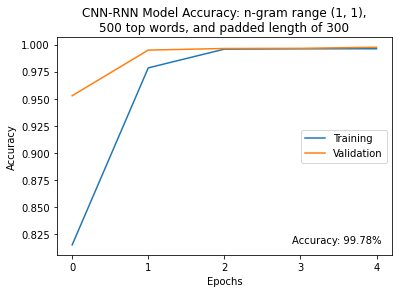

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n500 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92ccf05b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

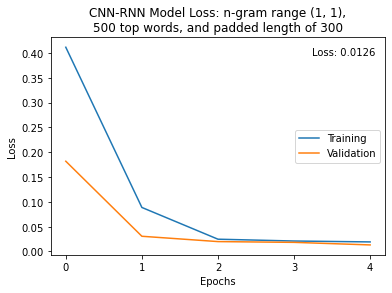

Updated model metrics for top 500 words, an n-gram range of (1, 1), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_500words_(1, 1)range_300maxLength.tf  (1, 1)             500              300  0.012621     99.7782         274.147



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 497 words (3 misses)

CNN-RNN hybrid model structure using top 500 words, an n-gram range of (1, 1), and padded length of 600 is:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 600, 100)          50200     
                                                                 
 conv1d_5 (Conv1D)           (None, 600, 128)          64128     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 300, 128)         0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)    

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n500 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d5d10a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

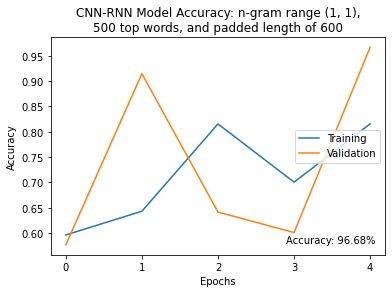

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n500 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d613c70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

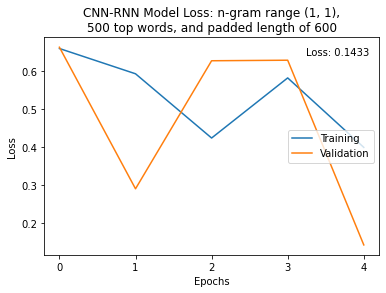

Updated model metrics for top 500 words, an n-gram range of (1, 1), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_500words_(1, 1)range_600maxLength.tf  (1, 1)             500              600  0.143326      96.685         495.492



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 996 words (4 misses)

CNN-RNN hybrid model structure using top 1000 words, an n-gram range of (1, 1), and padded length of 300 is:
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 300, 100)          100200    
                                                                 
 conv1d_6 (Conv1D)           (None, 300, 128)          64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)   

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n1000 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92f334970>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

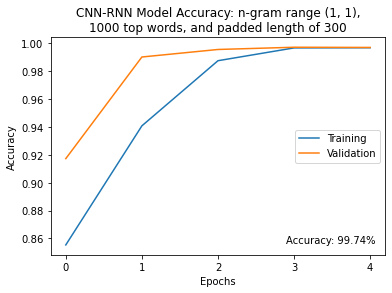

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n1000 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d669220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

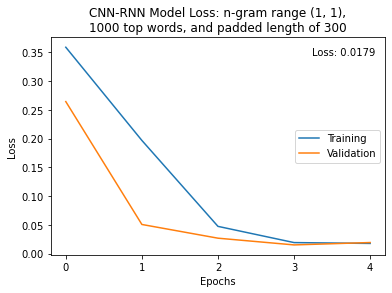

Updated model metrics for top 1000 words, an n-gram range of (1, 1), and padded length of 300 are:
model                                                       n_grams      key_words    padded_length       loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_1000words_(1, 1)range_300maxLength.tf  (1, 1)            1000              300  0.0179278     99.7432         272.641



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 996 words (4 misses)

CNN-RNN hybrid model structure using top 1000 words, an n-gram range of (1, 1), and padded length of 600 is:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_7 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, 600, 100)          100200    
                                                                 
 conv1d_7 (Conv1D)           (None, 600, 128)          64128     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 300, 128)         0         
 1D)                                                             
                                                                 
 lstm_7 (LSTM)   

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n1000 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f91eb17940>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

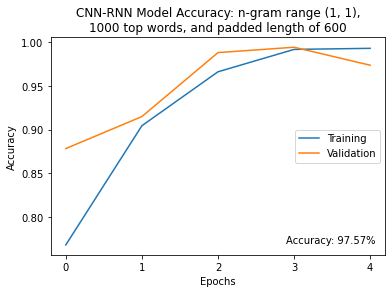

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n1000 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92c099280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

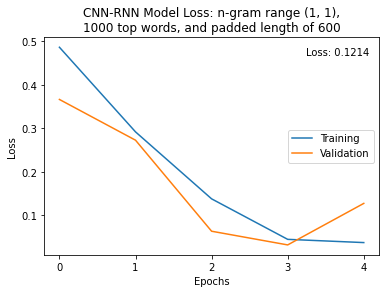

Updated model metrics for top 1000 words, an n-gram range of (1, 1), and padded length of 600 are:
model                                                       n_grams      key_words    padded_length      loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_1000words_(1, 1)range_600maxLength.tf  (1, 1)            1000              600  0.121421     97.5721         545.061



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 4982 words (18 misses)

CNN-RNN hybrid model structure using top 5000 words, an n-gram range of (1, 1), and padded length of 300 is:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 300, 100)          500200    
                                                                 
 conv1d_8 (Conv1D)           (None, 300, 128)          64128     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 lstm_8 (LSTM) 

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n5000 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f910dbf6a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

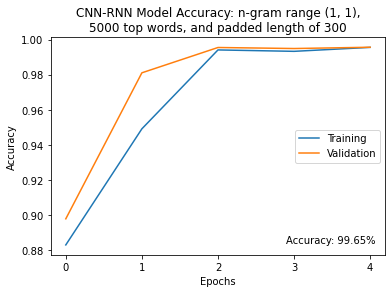

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n5000 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f910dffd60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

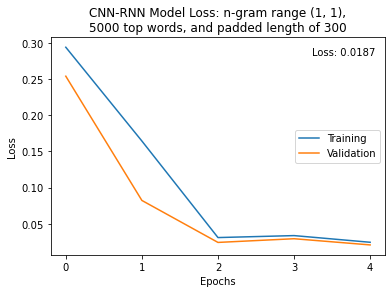

Updated model metrics for top 5000 words, an n-gram range of (1, 1), and padded length of 300 are:
model                                                       n_grams      key_words    padded_length      loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_5000words_(1, 1)range_300maxLength.tf  (1, 1)            5000              300  0.018725     99.6498         276.598



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 4982 words (18 misses)

CNN-RNN hybrid model structure using top 5000 words, an n-gram range of (1, 1), and padded length of 600 is:
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 600, 100)          500200    
                                                                 
 conv1d_9 (Conv1D)           (None, 600, 128)          64128     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 300, 128)         0         
 1D)                                                             
                                                                 
 lstm_9 (LSTM) 

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 1),\n5000 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f914e53eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

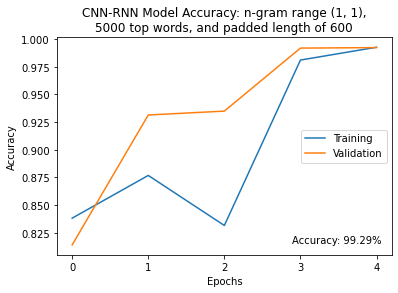

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 1),\n5000 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f914e9ab20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

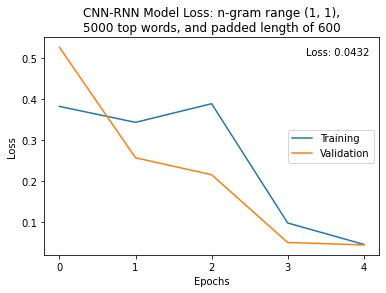

Updated model metrics for top 5000 words, an n-gram range of (1, 1), and padded length of 600 are:
model                                                       n_grams      key_words    padded_length       loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_5000words_(1, 1)range_600maxLength.tf  (1, 1)            5000              600  0.0432454      99.288         503.033



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 95 words (5 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (1, 2), and padded length of 300 is:
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_10 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_10 (Embedding)    (None, 300, 100)          10200     
                                                                 
 conv1d_10 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_10 (LSTM)   

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f934f81790>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

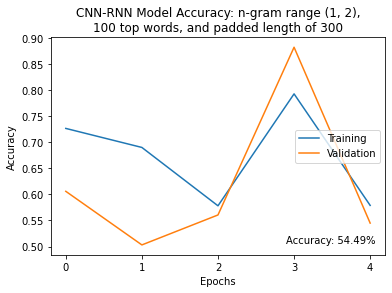

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f934fe0940>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

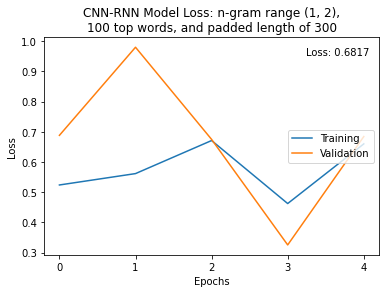

Updated model metrics for top 100 words, an n-gram range of (1, 2), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_100words_(1, 2)range_300maxLength.tf  (1, 2)             100              300  0.681692     54.4882         283.483



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 95 words (5 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (1, 2), and padded length of 600 is:
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_11 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_11 (Embedding)    (None, 600, 100)          10200     
                                                                 
 conv1d_11 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_11 (LSTM)   

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f91eb652b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

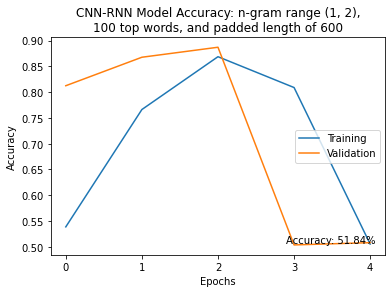

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92c4319a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

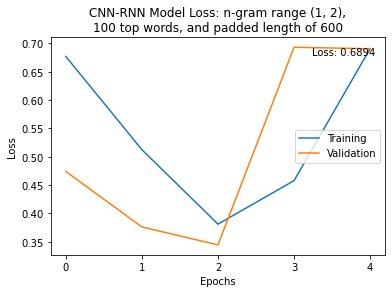

Updated model metrics for top 100 words, an n-gram range of (1, 2), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length     loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  -------  ----------  --------------
best_weights_cnn-rnn_100words_(1, 2)range_600maxLength.tf  (1, 2)             100              600  0.68936     51.8385         634.231



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 193 words (7 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (1, 2), and padded length of 300 is:
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_12 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_12 (Embedding)    (None, 300, 100)          20200     
                                                                 
 conv1d_12 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_12 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90c300850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

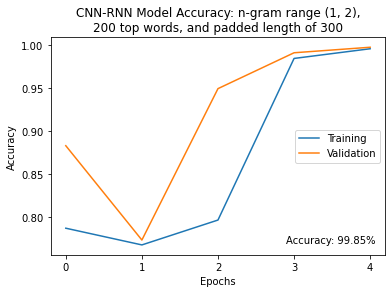

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90c3317f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

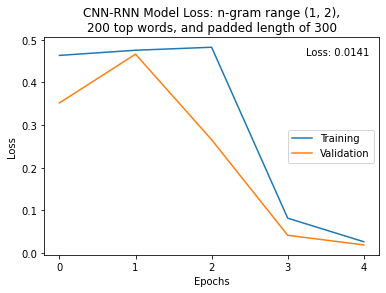

Updated model metrics for top 200 words, an n-gram range of (1, 2), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length       loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_200words_(1, 2)range_300maxLength.tf  (1, 2)             200              300  0.0141336     99.8483         292.966



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 193 words (7 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (1, 2), and padded length of 600 is:
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_13 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_13 (Embedding)    (None, 600, 100)          20200     
                                                                 
 conv1d_13 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_13 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n200 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90d9b57c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

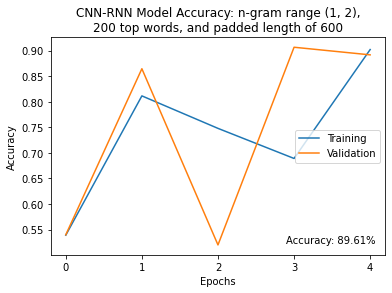

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n200 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90da113d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

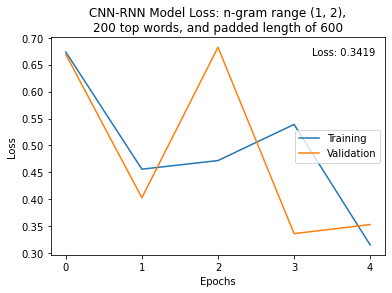

Updated model metrics for top 200 words, an n-gram range of (1, 2), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length     loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  -------  ----------  --------------
best_weights_cnn-rnn_200words_(1, 2)range_600maxLength.tf  (1, 2)             200              600  0.34189     89.6113         622.783



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 472 words (28 misses)

CNN-RNN hybrid model structure using top 500 words, an n-gram range of (1, 2), and padded length of 300 is:
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_14 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_14 (Embedding)    (None, 300, 100)          50200     
                                                                 
 conv1d_14 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_14 (LSTM) 

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n500 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f910bee7f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

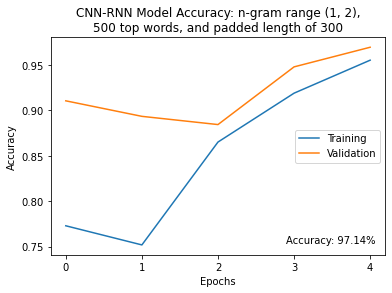

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n500 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f910d3a430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

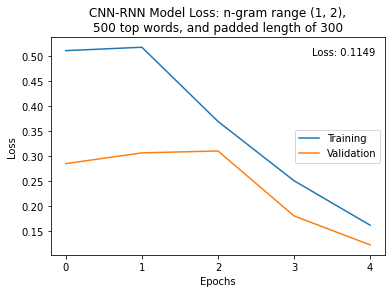

Updated model metrics for top 500 words, an n-gram range of (1, 2), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_500words_(1, 2)range_300maxLength.tf  (1, 2)             500              300  0.114864     97.1402          361.12



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 472 words (28 misses)

CNN-RNN hybrid model structure using top 500 words, an n-gram range of (1, 2), and padded length of 600 is:
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_15 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_15 (Embedding)    (None, 600, 100)          50200     
                                                                 
 conv1d_15 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_15 (LSTM) 

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n500 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f96cb81ac0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

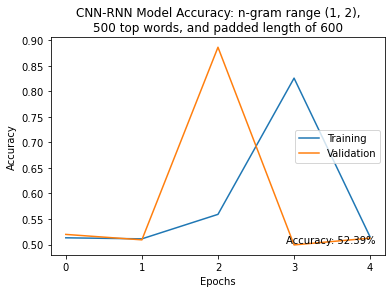

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n500 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d601eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

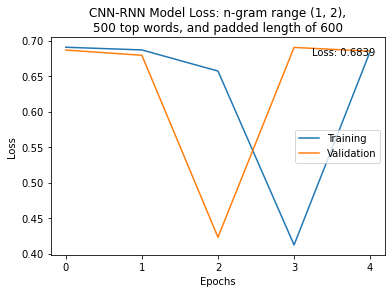

Updated model metrics for top 500 words, an n-gram range of (1, 2), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_500words_(1, 2)range_600maxLength.tf  (1, 2)             500              600  0.683929     52.3871         2363.54



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 940 words (60 misses)

CNN-RNN hybrid model structure using top 1000 words, an n-gram range of (1, 2), and padded length of 300 is:
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_16 (Embedding)    (None, 300, 100)          100200    
                                                                 
 conv1d_16 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_16 (LSTM)

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n1000 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d29b1c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

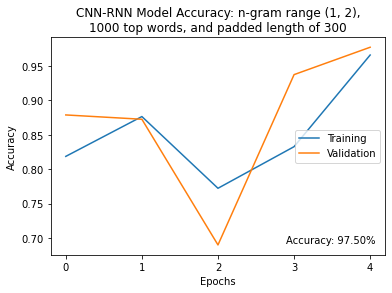

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n1000 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90c4e4d90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

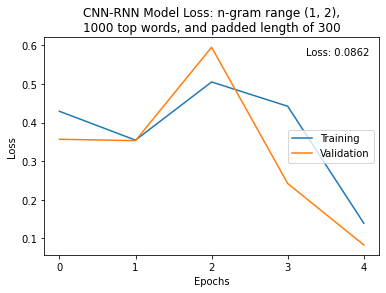

Updated model metrics for top 1000 words, an n-gram range of (1, 2), and padded length of 300 are:
model                                                       n_grams      key_words    padded_length       loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_1000words_(1, 2)range_300maxLength.tf  (1, 2)            1000              300  0.0861601      97.502         983.164



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 940 words (60 misses)

CNN-RNN hybrid model structure using top 1000 words, an n-gram range of (1, 2), and padded length of 600 is:
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_17 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_17 (Embedding)    (None, 600, 100)          100200    
                                                                 
 conv1d_17 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_17 (LSTM)

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n1000 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90df6c700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

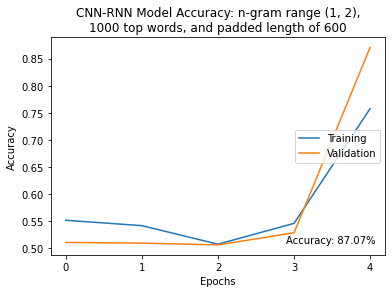

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n1000 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d14b550>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

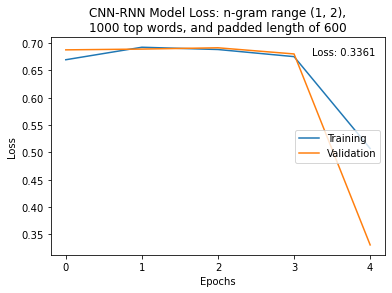

Updated model metrics for top 1000 words, an n-gram range of (1, 2), and padded length of 600 are:
model                                                       n_grams      key_words    padded_length      loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_1000words_(1, 2)range_600maxLength.tf  (1, 2)            1000              600  0.336087     87.0667         1263.76



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 4117 words (883 misses)

CNN-RNN hybrid model structure using top 5000 words, an n-gram range of (1, 2), and padded length of 300 is:
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_18 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_18 (Embedding)    (None, 300, 100)          500200    
                                                                 
 conv1d_18 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_18 (LST

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n5000 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90aab72e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

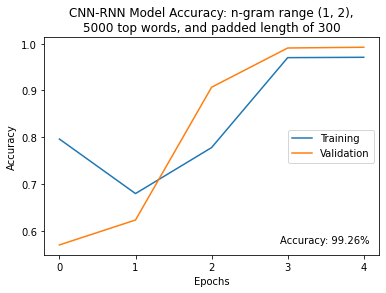

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n5000 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90aaf2f40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

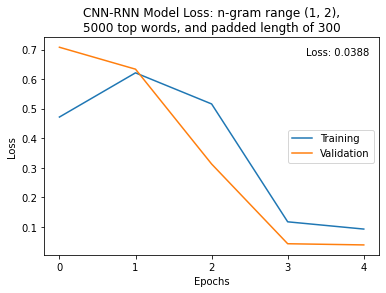

Updated model metrics for top 5000 words, an n-gram range of (1, 2), and padded length of 300 are:
model                                                       n_grams      key_words    padded_length       loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_5000words_(1, 2)range_300maxLength.tf  (1, 2)            5000              300  0.0387836     99.2646         710.105



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 4117 words (883 misses)

CNN-RNN hybrid model structure using top 5000 words, an n-gram range of (1, 2), and padded length of 600 is:
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_19 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_19 (Embedding)    (None, 600, 100)          500200    
                                                                 
 conv1d_19 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_19 (LST

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 2),\n5000 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90c6af730>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

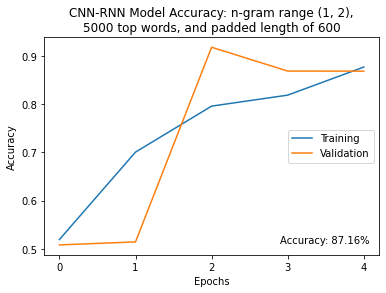

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 2),\n5000 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92e766730>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

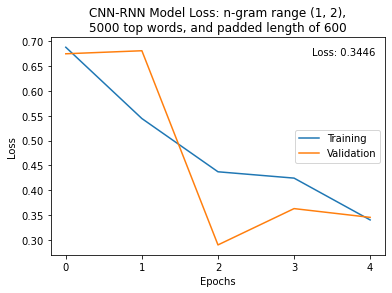

Updated model metrics for top 5000 words, an n-gram range of (1, 2), and padded length of 600 are:
model                                                       n_grams      key_words    padded_length      loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_5000words_(1, 2)range_600maxLength.tf  (1, 2)            5000              600  0.344639       87.16         2301.02



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (100 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (2, 2), and padded length of 300 is:
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_20 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_20 (Embedding)    (None, 300, 100)          10200     
                                                                 
 conv1d_20 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_20 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f925c5d760>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

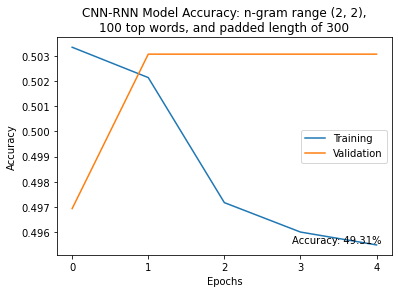

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f9111fbfd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

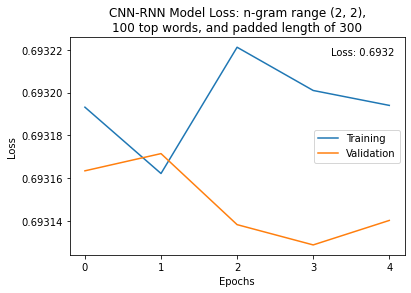

Updated model metrics for top 100 words, an n-gram range of (2, 2), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_100words_(2, 2)range_300maxLength.tf  (2, 2)             100              300  0.693167     49.3055         927.259



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (100 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (2, 2), and padded length of 600 is:
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_21 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_21 (Embedding)    (None, 600, 100)          10200     
                                                                 
 conv1d_21 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_21 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f9124e1ee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

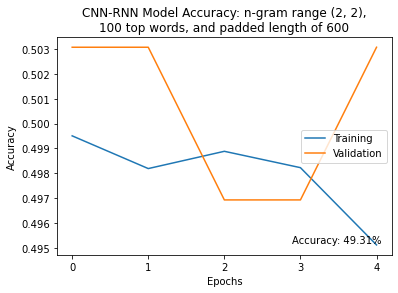

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90de6fee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

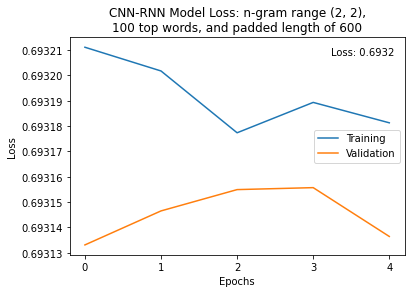

Updated model metrics for top 100 words, an n-gram range of (2, 2), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_100words_(2, 2)range_600maxLength.tf  (2, 2)             100              600  0.693179     49.3055         1378.06



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (200 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (2, 2), and padded length of 300 is:
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_22 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_22 (Embedding)    (None, 300, 100)          20200     
                                                                 
 conv1d_22 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_22 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f926d3a4f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

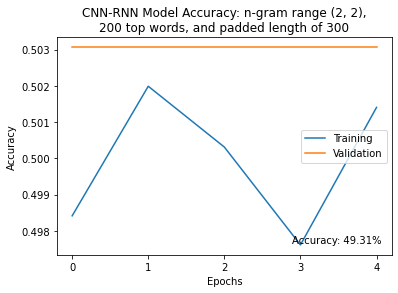

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90dc52640>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

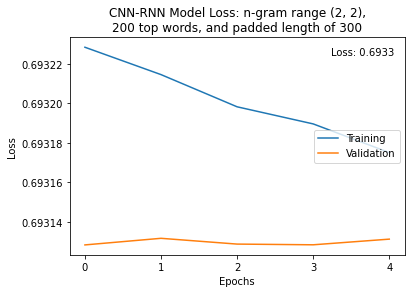

Updated model metrics for top 200 words, an n-gram range of (2, 2), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_200words_(2, 2)range_300maxLength.tf  (2, 2)             200              300  0.693299     49.3055         533.568



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (200 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (2, 2), and padded length of 600 is:
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_23 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_23 (Embedding)    (None, 600, 100)          20200     
                                                                 
 conv1d_23 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_23 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n200 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92ee1de80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

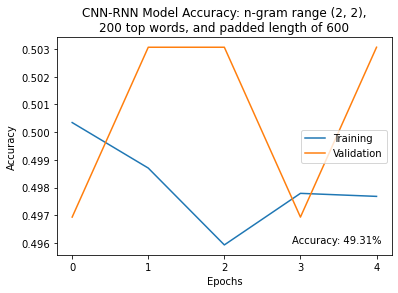

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n200 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92ee78cd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

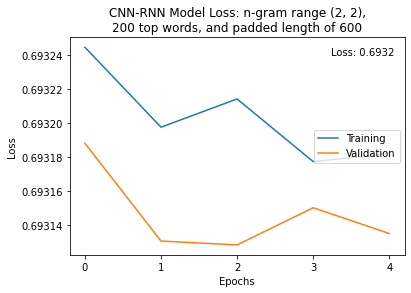

Updated model metrics for top 200 words, an n-gram range of (2, 2), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_200words_(2, 2)range_600maxLength.tf  (2, 2)             200              600  0.693184     49.3055         1559.78



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (500 misses)

CNN-RNN hybrid model structure using top 500 words, an n-gram range of (2, 2), and padded length of 300 is:
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_24 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_24 (Embedding)    (None, 300, 100)          50200     
                                                                 
 conv1d_24 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_24 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n500 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f934ff37f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

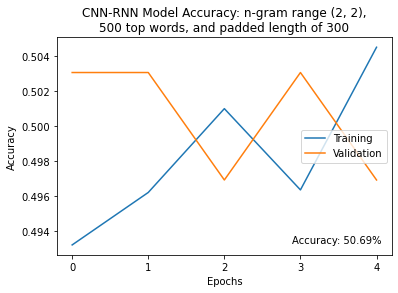

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n500 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90c249af0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

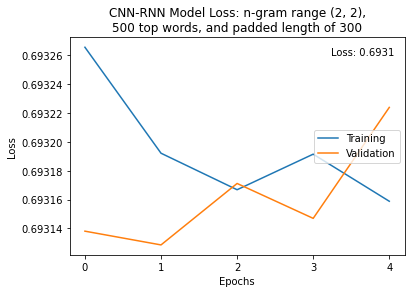

Updated model metrics for top 500 words, an n-gram range of (2, 2), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length     loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  -------  ----------  --------------
best_weights_cnn-rnn_500words_(2, 2)range_300maxLength.tf  (2, 2)             500              300  0.69307     50.6945         529.735



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (500 misses)

CNN-RNN hybrid model structure using top 500 words, an n-gram range of (2, 2), and padded length of 600 is:
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_25 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_25 (Embedding)    (None, 600, 100)          50200     
                                                                 
 conv1d_25 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_25 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n500 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f913a38220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

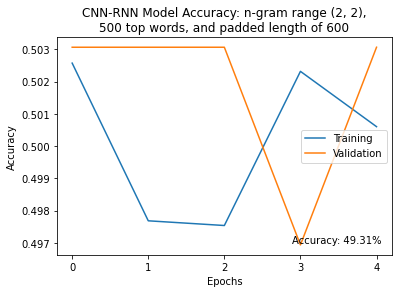

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n500 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f91117b2e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

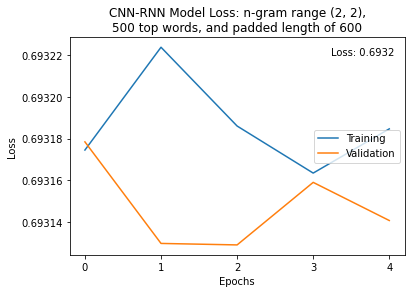

Updated model metrics for top 500 words, an n-gram range of (2, 2), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_500words_(2, 2)range_600maxLength.tf  (2, 2)             500              600  0.693165     49.3055         859.318



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (1000 misses)

CNN-RNN hybrid model structure using top 1000 words, an n-gram range of (2, 2), and padded length of 300 is:
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_26 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_26 (Embedding)    (None, 300, 100)          100200    
                                                                 
 conv1d_26 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_26 (LSTM)

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n1000 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90c111820>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

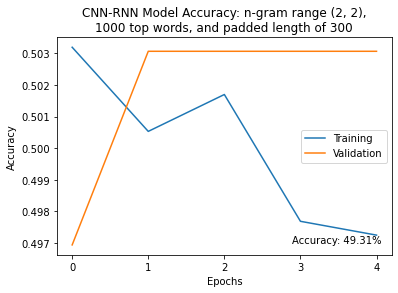

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n1000 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f918a56e20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

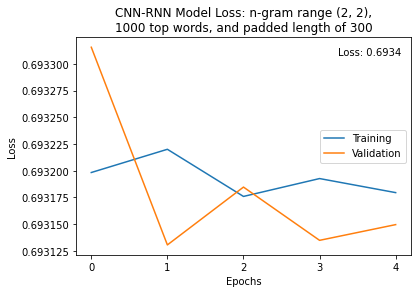

Updated model metrics for top 1000 words, an n-gram range of (2, 2), and padded length of 300 are:
model                                                       n_grams      key_words    padded_length      loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_1000words_(2, 2)range_300maxLength.tf  (2, 2)            1000              300  0.693402     49.3055         386.959



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (1000 misses)

CNN-RNN hybrid model structure using top 1000 words, an n-gram range of (2, 2), and padded length of 600 is:
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_27 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_27 (Embedding)    (None, 600, 100)          100200    
                                                                 
 conv1d_27 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_27 (LSTM)

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n1000 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90acd4c40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

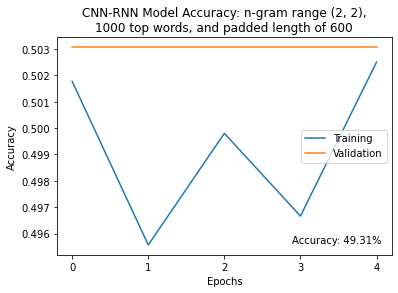

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n1000 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f93242e820>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

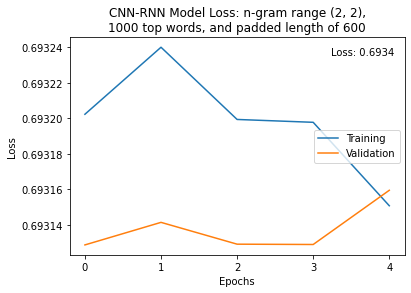

Updated model metrics for top 1000 words, an n-gram range of (2, 2), and padded length of 600 are:
model                                                       n_grams      key_words    padded_length     loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  -------  ----------  --------------
best_weights_cnn-rnn_1000words_(2, 2)range_600maxLength.tf  (2, 2)            1000              600  0.69344     49.3055         863.646



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (5000 misses)

CNN-RNN hybrid model structure using top 5000 words, an n-gram range of (2, 2), and padded length of 300 is:
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_28 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_28 (Embedding)    (None, 300, 100)          500200    
                                                                 
 conv1d_28 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_28 (LSTM)

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n5000 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f925c777c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

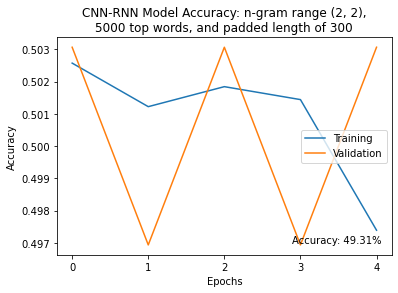

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n5000 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d742a30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

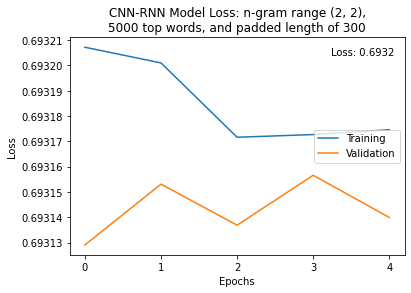

Updated model metrics for top 5000 words, an n-gram range of (2, 2), and padded length of 300 are:
model                                                       n_grams      key_words    padded_length      loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_5000words_(2, 2)range_300maxLength.tf  (2, 2)            5000              300  0.693167     49.3055         1386.08



['',
 '[UNK]',
 'donald trump',
 'united state',
 'white house',
 'hillary clinton',
 'new york',
 'featured image',
 'north korea',
 'president donald']

Found 400000 word vectors.

Converted 0 words (5000 misses)

CNN-RNN hybrid model structure using top 5000 words, an n-gram range of (2, 2), and padded length of 600 is:
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_29 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_29 (Embedding)    (None, 600, 100)          500200    
                                                                 
 conv1d_29 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_29 (LSTM)

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (2, 2),\n5000 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f9164f7dc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

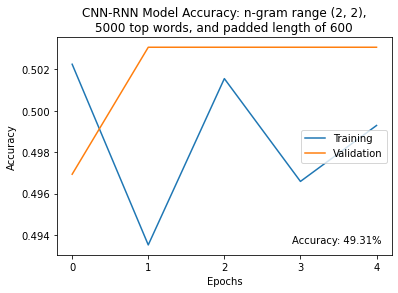

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (2, 2),\n5000 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92c00f220>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

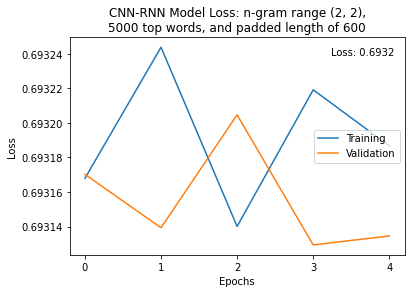

Updated model metrics for top 5000 words, an n-gram range of (2, 2), and padded length of 600 are:
model                                                       n_grams      key_words    padded_length      loss    accuracy    elapsed_time
----------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_5000words_(2, 2)range_600maxLength.tf  (2, 2)            5000              600  0.693187     49.3055         2000.69



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 98 words (2 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (1, 3), and padded length of 300 is:
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_30 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_30 (Embedding)    (None, 300, 100)          10200     
                                                                 
 conv1d_30 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_30 (LSTM)   

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 3),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92d24f280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

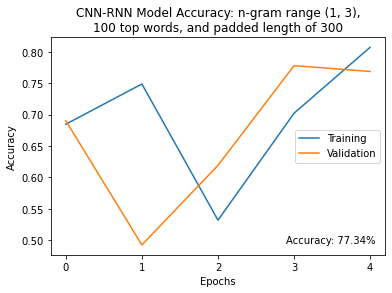

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 3),\n100 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90c52e940>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

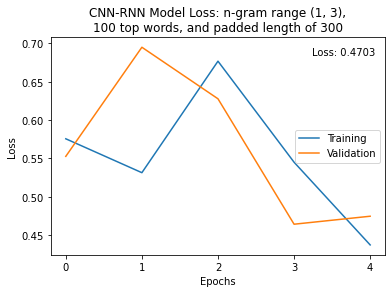

Updated model metrics for top 100 words, an n-gram range of (1, 3), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_100words_(1, 3)range_300maxLength.tf  (1, 3)             100              300  0.470257     77.3433          779.43



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 98 words (2 misses)

CNN-RNN hybrid model structure using top 100 words, an n-gram range of (1, 3), and padded length of 600 is:
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_31 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_31 (Embedding)    (None, 600, 100)          10200     
                                                                 
 conv1d_31 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_31 (LSTM)   

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 3),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f914f82af0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

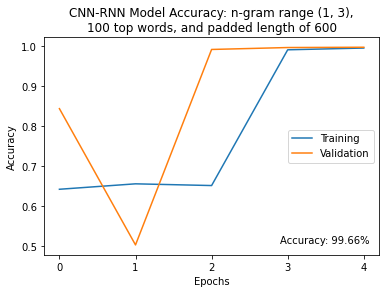

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 3),\n100 top words, and padded length of 600')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f90f27cd60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

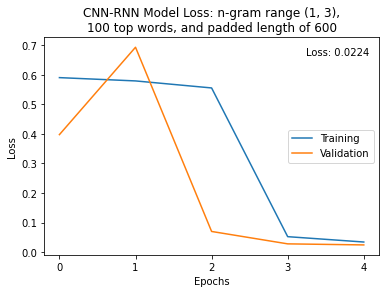

Updated model metrics for top 100 words, an n-gram range of (1, 3), and padded length of 600 are:
model                                                      n_grams      key_words    padded_length       loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  ---------  ----------  --------------
best_weights_cnn-rnn_100words_(1, 3)range_600maxLength.tf  (1, 3)             100              600  0.0223964     99.6615         1855.03



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 198 words (2 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (1, 3), and padded length of 300 is:
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_32 (Text  (None, 300)              0         
 Vectorization)                                                  
                                                                 
 embedding_32 (Embedding)    (None, 300, 100)          20200     
                                                                 
 conv1d_32 (Conv1D)          (None, 300, 128)          64128     
                                                                 
 max_pooling1d_32 (MaxPoolin  (None, 150, 128)         0         
 g1D)                                                            
                                                                 
 lstm_32 (LSTM)  

Text(0.5, 1.0, 'CNN-RNN Model Accuracy: n-gram range (1, 3),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f921f4da30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

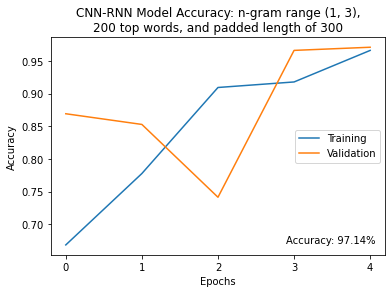

Text(0.5, 1.0, 'CNN-RNN Model Loss: n-gram range (1, 3),\n200 top words, and padded length of 300')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

([<matplotlib.axis.XTick at 0x1f92cb2bd60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

[None, None]

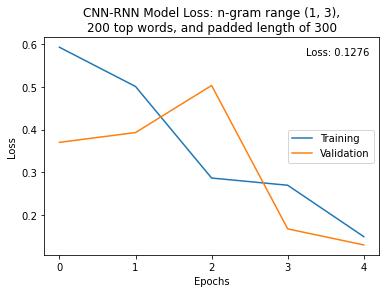

Updated model metrics for top 200 words, an n-gram range of (1, 3), and padded length of 300 are:
model                                                      n_grams      key_words    padded_length      loss    accuracy    elapsed_time
---------------------------------------------------------  ---------  -----------  ---------------  --------  ----------  --------------
best_weights_cnn-rnn_200words_(1, 3)range_300maxLength.tf  (1, 3)             200              300  0.127586     97.1402         1109.48



['',
 '[UNK]',
 'trump',
 'said',
 'state',
 'president',
 'would',
 'year',
 'people',
 'republican']

Found 400000 word vectors.

Converted 198 words (2 misses)

CNN-RNN hybrid model structure using top 200 words, an n-gram range of (1, 3), and padded length of 600 is:
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_33 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_33 (Embedding)    (None, 600, 100)          20200     
                                                                 
 conv1d_33 (Conv1D)          (None, 600, 128)          64128     
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 300, 128)         0         
 g1D)                                                            
                                                                 
 lstm_33 (LSTM)  

KeyboardInterrupt: 

In [13]:
# ngrams parameter defines phrase length and iterates over n_grams list.
# (1, 1) keeps single words only, (3,3) keeps three word phrases,
# (1, 3) keeps one, two, or three word phrases in top n words and so on.
for ng in n_grams:

    # Max tokens parameter chooses the top n words (iterate over key_words list)
    for kw in key_words:
        
        # output_sequence_length parameter defines the sequence length to pad the outputs to
        # iterates over values in max_len list.
        for ml in max_len:

            # Create the vocabulary index. 
            vectorizer = tf.keras.layers.TextVectorization(
                max_tokens = kw, # number of top key words to keep
                standardize = None, # data already cleaned above
                split = 'whitespace', # already split tokens during data cleaning
                ngrams = ng, # range of token string lengths to keep in max_tokens (unigram, bigram, trigram)
                output_mode = 'int', # outputs one integer index per split string token
                output_sequence_length = ml, # if set, output will have its time (length) dimension padded to exactly the specified value
                pad_to_max_tokens = False, # not valid argument for integer outputs
                vocabulary = None, # optional, the adapt layer below handle's this step better
                idf_weights = None, # not valid argument for integer outputs
                sparse = False, # not applicable argument for integer outputs
                ragged = False, # false cause you want each sequence shrunk or padded to the same output_sequence_length
            )

            # Now that the vocab layer has been created, call `adapt` on the text-only
            # dataset to create the vocabulary. You don't have to batch, but for large
            # datasets this means we're not keeping spare copies of the dataset.
            vectorizer.adapt(text_dataset)
            
            # Retrieve the top 10 words from vectorized vocabulary
            vectorizer.get_vocabulary()[:10]

            # Create a dictionary mapping words to their indices
            voc = vectorizer.get_vocabulary()
            word_index = dict(zip(voc, range(len(voc))))

            # Make a dictionary mapping strings to their NumPy vector representation in gloVe:
            data_dir = 'E:/Zack/School/Classes/Summer 22/CSC 7333 - Machine Learning/Group Project/glove.6B.100d.txt'

            embeddings_index = {}
            with open(data_dir, encoding = "utf8") as f:
                for line in f:
                    word, coefs = line.split(maxsplit = 1)
                    coefs = np.fromstring(coefs, "f", sep = " ")
                    embeddings_index[word] = coefs

            print("Found %s word vectors." % len(embeddings_index))
            print()

            # Prepare a corresponding embedding matrix to use in the model's Embedding layer
            num_tokens = len(voc) + 2 # plus 2 because 0 is reserved for padding and 1 is reserved for tokens not in vocab
            embedding_dim = 100
            hits = 0
            misses = 0

            # Prepare embedding matrix
            embedding_matrix = np.zeros((num_tokens, embedding_dim))
            for word, i in word_index.items():
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    # Words not found in embedding index will be all-zeros.
                    # This includes the representation for "padding" and tokens not in vocabulary index
                    embedding_matrix[i] = embedding_vector
                    hits += 1
                else:
                    misses += 1
            print("Converted %d words (%d misses)" % (hits, misses))
            print()
            
            # Create the model that uses the vectorized text layer
            model = Sequential()

            # Start by creating an explicit input layer. It needs to have a shape of
            # (1,) (because we need to guarantee that there is exactly one string
            # input per batch), and the dtype needs to be 'string'.
            model.add(tf.keras.Input(shape = (1,), dtype = tf.string))

            # The first layer in our model is the vectorization layer. After this layer,
            # we have a tensor of shape (batch_size, max_len) containing vocab indices
            model.add(vectorizer)

            # Now, the model can map strings to integers, and you can add an embedding
            # layer to map these integers to learned embeddings.
            model.add(Embedding(
                num_tokens, # kw (or voc) + 2
                embedding_dim, # 100 dimension matrix
                input_length = ml, # size of the padded sequence
                embeddings_initializer = keras.initializers.Constant(embedding_matrix), # intialize based on your embedding matrix
                trainable = False # set to false so you don't update embedding during training
            ))

            # Finish building the model
            model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu')) # extract local features using 128 filters with kernel size of 5 and default ReLU activiation function
            model.add(MaxPooling1D(pool_size = 2)) # pool large vector features from above CNN layer with window size of 2--this downsamples the feature vectors/parameters
            model.add(LSTM(32)) # this is your RNN (long short-term memory (LSTM)) layer; the pooled features from above layer are the input w/ default hyperbolic tangent activation
            model.add(Dense(1, activation = 'sigmoid')) # this layer classifies the trained vector features and shrinks the output dimension to 1, which corresponds to classification label. 
            model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # train the model using batch size 64 across 10 epochs using adaptive moment estimation (ADAM) to define learning rate in each epoch

            # CNN-RNN hybrid model structure: 
            print(f"CNN-RNN hybrid model structure using top {kw} words, an n-gram range of {ng}, and padded length of {ml} is:") 
            print(model.summary())
            print()

            # Create variable for storing start time
            start_time = time.time()

            # Save model weights 
            filepath = f"best_weights_cnn-rnn_{kw}words_{ng}range_{ml}maxLength.tf"
            checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max', save_weights_only = True)
            callbacks_list = [checkpoint]
            history = model.fit(train_data, train_target, epochs = 5, batch_size = 64, verbose = 1, callbacks = callbacks_list, validation_split = 0.2) # fit the model on training data

            # Evaluate the model
            scores = model.evaluate(test_data, test_target, verbose = 1)
            loss = (scores[0]) # store best loss value
            accuracy = (scores[1]*100) # store best accuracy value
            print(f"CNN-RNN hybrid model accuracy using top {kw}, an n-gram range of {ng}, and padded length of {ml} is: {accuracy:.2f}%")
            print()

            # Create variable for storing current time
            # Subtract start time from current time to get runtime
            current_time = time.time()
            elapsed_time = current_time - start_time
            print(f"Model training and evaluation time using top {kw} words, an n-gram range of {ng}, and padded length of {ml} is: {elapsed_time:.2f} seconds")
            print()

            # Training and validation accuracy
            fig, ax = plt.subplots()
            plt.plot(history.history['accuracy']) # training accuracy
            plt.plot(history.history['val_accuracy']) # validation accuracy
            plt.title(f'CNN-RNN Model Accuracy: n-gram range {ng},\n{kw} top words, and padded length of {ml}')
            plt.legend(['Training', 'Validation'], loc = 'center right')
            plt.ylabel('Accuracy')
            plt.xlabel('Epochs')
            plt.xticks([0, 1, 2, 3, 4])
            text_box = AnchoredText(f"Accuracy: {accuracy:.2f}%", loc = 'lower right', frameon = False, pad = 0.5)
            plt.setp(text_box.patch, facecolor = 'white', alpha = 0.5)
            ax.add_artist(text_box)
            plt.show();

            # Training and validation loss
            fig, ax = plt.subplots()
            plt.plot(history.history['loss']) # training accuracy
            plt.plot(history.history['val_loss']) # validation accuracy
            plt.title(f'CNN-RNN Model Loss: n-gram range {ng},\n{kw} top words, and padded length of {ml}')
            plt.ylabel('Loss')
            plt.xlabel('Epochs')
            plt.xticks([0, 1, 2, 3, 4])
            plt.legend(['Training', 'Validation'], loc = 'center right')
            text_box = AnchoredText(f"Loss: {loss:.4f}", loc = 'upper right', frameon = False, pad = 0.5)
            plt.setp(text_box.patch, facecolor = 'white', alpha = 0.5)
            ax.add_artist(text_box)
            plt.show();

            # Create empty dictionary to append model metrics to
            # Not sure why this isn't appending values to a list
            modelMetrics = [('model', filepath), ('n_grams', ng), ('key_words', kw), ('padded_length', ml), ('loss', loss), ('accuracy', accuracy), ('elapsed_time', elapsed_time)]
            metrics_dict = defaultdict(list)
            for k, v in modelMetrics:
                metrics_dict[k].append(v)

            print(f"Updated model metrics for top {kw} words, an n-gram range of {ng}, and padded length of {ml} are:")
            print(tabulate(metrics_dict, headers = 'keys'))
            print();